<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import re
import os
import gdown
import json
import logging
from pathlib import Path
from io import StringIO
import pickle

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences, plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Dense, Flatten, LSTM, SimpleRNN, Embedding, Input, Attention, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [ ]:
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://convai.io/data/data_volunteers.json'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://convai.io/data/data_volunteers.json
To: /content/data_volunteers.json
2.58MB [00:00, 128MB/s]                   


In [ ]:
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)

In [ ]:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [ ]:
START_TOKEN = '<sos>'
END_TOKEN   = '<eos>'
OOV_TOKEN   = '<unk>'

chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        output_sentence = output + ' '
        output_sentence_input  = f'{START_TOKEN} {output}'

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [ ]:
MAX_VOCAB_SIZE=40000

input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
max_input_len = max(len(sen) for sen in input_integer_seq)
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len, padding='post')

output_sentences_inputs = [f'{START_TOKEN} ' + sentence for sentence in output_sentences]
output_sentences_targets = [sentence + f' {END_TOKEN}' for sentence in output_sentences]

output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!\"#$%&()*+,-./:;=?@[\\]^_`{|}~', oov_token=OOV_TOKEN)
output_tokenizer.fit_on_texts(output_sentences_inputs + output_sentences_targets)

output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
output_target_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_targets)

word2idx_outputs = output_tokenizer.word_index
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_target_integer_seq)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_target_sequences = pad_sequences(output_target_integer_seq, maxlen=max_out_len, padding='post')

decoder_targets = np.zeros((len(decoder_target_sequences), max_out_len, num_words_output), dtype='float32')

for i, target_seq in enumerate(decoder_target_sequences):
    for t, word_idx in enumerate(target_seq):
        if word_idx > 0:
            decoder_targets[i, t, word_idx] = 1.0

decoder_targets = to_categorical(decoder_target_sequences, num_classes=num_words_output)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [ ]:
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

--2025-04-26 22:39:55--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2025-04-26 22:39:55--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  4.41MB/s    in 12m 18s 

2025-04-26 22:52:14 (2.81 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [ ]:
embedding_dim = 300

embedding_index = {}
with open("glove.840B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.rstrip().split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs
print(f"Loaded {len(embedding_index):,} word vectors")

vocab_size = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype="float32")

for word, i in word2idx_inputs.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 2,196,016 word vectors


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [ ]:
n_units        = 200
max_input_len  = encoder_input_sequences.shape[1]
max_out_len    = decoder_input_sequences.shape[1]
vocab_inp_size = vocab_size
vocab_out_size = num_words_output

# ---------- ENCODER ----------
enc_inputs  = Input(shape=(max_input_len,), name="encoder_inputs")
enc_emb     = Embedding(input_dim=vocab_inp_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        trainable=False,
                        name="enc_embedding")(enc_inputs)

enc_lstm    = LSTM(n_units,
                   return_sequences=True,
                   return_state=True,
                   dropout=0.2,
                   name="enc_lstm")
enc_outputs, state_h, state_c = enc_lstm(enc_emb)
enc_states = [state_h, state_c]

# ---------- DECODER ----------
dec_inputs  = Input(shape=(max_out_len,), name="decoder_inputs")
dec_emb_layer = Embedding(input_dim=vocab_out_size,
                        output_dim=n_units,
                        name="dec_embedding")
dec_emb     = dec_emb_layer(dec_inputs)

dec_lstm    = LSTM(n_units,
                   return_sequences=True,
                   return_state=True,
                   dropout=0.2,
                   name="dec_lstm")
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state=enc_states)

# ---------- ATENCIÓN ----------
attn_layer  = Attention(name="attention_layer")
context     = attn_layer([dec_outputs, enc_outputs])

dec_concat  = Concatenate(axis=-1, name="concat_layer")([dec_outputs, context])

# ---------- CAPA DE SALIDA ----------
dec_dense   = Dense(vocab_out_size, activation='softmax', name="output_dense")
final_outputs = dec_dense(dec_concat)

# ---------- MODELO DE ENTRENAMIENTO ----------
training_model = Model([enc_inputs, dec_inputs], final_outputs)
training_model.compile(optimizer="adam", loss="categorical_crossentropy",
                       metrics=["accuracy"])
training_model.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_embedding       │ (None, 9, 300)    │    540,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding       │ (None, 10, 200)   │    361,600 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_lstm (LSTM)     │ [(None, 9, 200),  │    400,800 │ enc_embedding[0]… │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_lstm (LSTM)     │ [(None, 10, 200), │    320,800 │ dec_embedding[0]… │
│                     │ (None, 200),      │            │ enc_lstm[0][1],   │
│                     │ (None, 200)]      │            │ enc_lstm[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 10, 200)   │          0 │ dec_lstm[0][0],   │
│ (Attention)         │                   │            │ enc_lstm[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 10, 400)   │          0 │ dec_lstm[0][0],   │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 10, 1808)  │    725,008 │ concat_layer[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,348,208 (8.96 MB)

 Trainable params: 1,808,208 (6.90 MB)

 Non-trainable params: 540,000 (2.06 MB)

In [ ]:
enc_inf_model = Model(enc_inputs, [enc_outputs, state_h, state_c])

dec_state_in_h = Input(shape=(n_units,), name="dec_state_in_h")
dec_state_in_c = Input(shape=(n_units,), name="dec_state_in_c")
enc_out_inf    = Input(shape=(max_input_len, n_units), name="enc_out_inf")

dec_emb_inf    = dec_emb_layer
step_emb       = dec_emb_inf(dec_inputs)
step_dec_out, step_h, step_c = dec_lstm(step_emb,
                                        initial_state=[dec_state_in_h,
                                                       dec_state_in_c])

step_context   = attn_layer([step_dec_out, enc_out_inf])
step_concat    = Concatenate(axis=-1)([step_dec_out, step_context])
step_out_token = dec_dense(step_concat)

dec_inf_model = Model([dec_inputs, enc_out_inf,
                       dec_state_in_h, dec_state_in_c],
                      [step_out_token, step_h, step_c])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = training_model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping]
    )

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5384 - loss: 3.4788 - val_accuracy: 0.6640 - val_loss: 2.0823
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6879 - loss: 1.7977 - val_accuracy: 0.6993 - val_loss: 1.8344
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7286 - loss: 1.5140 - val_accuracy: 0.7161 - val_loss: 1.7237
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7484 - loss: 1.3479 - val_accuracy: 0.7229 - val_loss: 1.6745
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7575 - loss: 1.2600 - val_accuracy: 0.7292 - val_loss: 1.6384
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7664 - loss: 1.1653 - val_accuracy: 0.7328 - val_loss: 1.6268
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7738 - loss: 1.1020 - val_accuracy: 0.7365 - val_loss: 1.6213
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7774 - loss: 1.0566 - val_accu

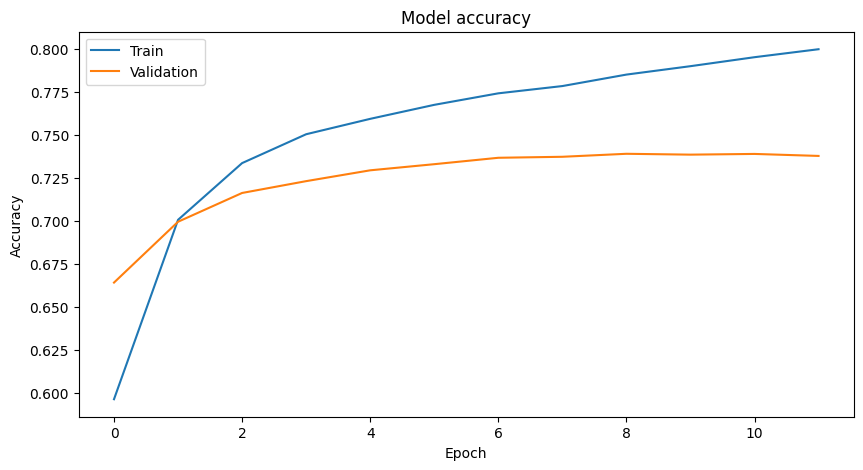

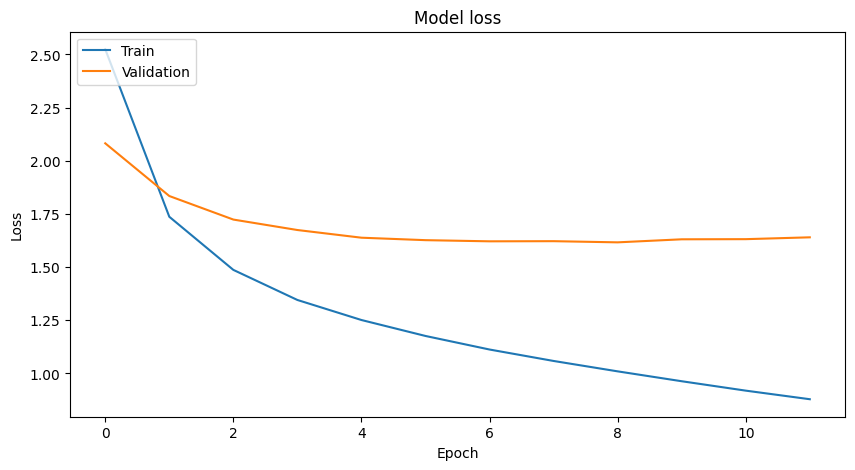

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
import tensorflow as tf

def get_response(input_text: str) -> str:
    def _to_ids(sentence: str):
        return [
            word2idx_inputs.get(tok, word2idx_inputs.get(OOV_TOKEN, 1))
            for tok in sentence.lower().split()
        ]

    seq = _to_ids(input_text)
    seq = tf.keras.preprocessing.sequence.pad_sequences(
        [seq], maxlen=max_input_len, padding="post"
    )

    enc_outs, st_h, st_c = enc_inf_model.predict(seq, verbose=0)
    target_seq = np.array([[word2idx_outputs[START_TOKEN]]], dtype="int32")

    eos_idx = word2idx_outputs[END_TOKEN]
    generated = []

    for _ in range(max_out_len):
        preds, st_h, st_c = dec_inf_model.predict(
            [target_seq, enc_outs, st_h, st_c], verbose=0
        )
        preds = preds[0, 0]

        idx = int(np.argmax(preds))

        if idx == eos_idx:
            break

        word = idx2word_target.get(idx, "")
        if word:
            generated.append(word)

        target_seq = np.array([[idx]], dtype="int32")

    return " ".join(generated) if generated else "(sin respuesta)"

In [ ]:
input_text = "Do you read?"
response = get_response(input_text)
print("output:", response)

output: yes i do


In [ ]:
input_text = "What is your name?"
response = get_response(input_text)
print("output:", response)

output: i am a teacher


In [ ]:
input_text = "Where are you from?"
response = get_response(input_text)
print("output:", response)

output: i am not sure what you mean


In [ ]:
input_text = "What is the weather like?"
response = get_response(input_text)
print("output:", response)

output: i like to go to the beach


In [ ]:
input_text = "Nice to meet you!"
response = get_response(input_text)
print("output:", response)

output: what do you do for a living


In [ ]:
input_text = "What do you do for a living?"
response = get_response(input_text)
print("output:", response)

output: i m a student


In [ ]:
input_text = "How are you?"
response = get_response(input_text)
print("output:", response)

output: i am doing well how are you


In [ ]:
input_text = "Do you like dogs?"
response = get_response(input_text)
print("output:", response)

output: yes i do


### Conclusiones
Las respuestas generadas son mixtas. Algunas son coherentes y apropiadas para preguntas simples ("Do you read?" -> "yes i do", "How are you?" -> "i am doing well how are you", "What do you do for a living?" -> "i m a student").

Otras respuestas, aunque gramaticalmente correctas, son semánticamente irrelevantes o genéricas ("What is the weather like?" -> "i like to go to the beach", "Nice to meet you!" -> "what do you do for a living"). Esto sugiere que el modelo no siempre captura el significado real de la pregunta o recurre a respuestas frecuentes en los datos.

Respuestas como "i am not sure what you mean" pueden ser indicativas de una incapacidad para manejar preguntas fuera de lo común en los datos o una respuesta genérica aprendida.


Viendo las metricas de entrenamiento y algunas de las respuestas, el modelo está memorizando el conjunto de entrenamiento en lugar de generalizar bien a datos no vistos.
